# Calcualte the Options PnL

In [1]:
from scipy.optimize import minimize
import math
import numpy as np
import pandas as pd
import FX_Volatility

In [2]:
# Create the Dataframe with spots and vols for risk_Metrics
spot_vols = pd.read_csv("data/FXspot_ATMvols_edates.csv") # without the first row of NA
spot_vols.index = pd.to_datetime(spot_vols['Date'])
del spot_vols['Date']
# Create the returns dataFrame
retfxvol = spot_vols.pct_change()[1:]
retfxvol.head(5)

,USDCNYspot,USDBRLspot,USDZARspot,USDRUBspot,EURUSDspot,USDJPYspot,USDMXNspot,USDCADspot,USDCNYvol,USDBRLvol,USDZARvol,USDRUBvol,EURUSDvol,USDJPYvol,USDMXNvol,USDCADvol
Date,,,,,,,,,,,,,,,,
2011-01-04,0.000091,0.007396,0.006232,0.000655,-0.003967,0.003670,-0.001731,0.004528,-0.067081,0.017004,0.002493,0.007121,-0.040077,-0.031344,0.014555,0.000000
2011-01-05,0.001846,0.007702,0.004064,-0.002400,-0.011948,0.014749,-0.003279,-0.002705,-0.042610,0.000398,0.008883,-0.001010,0.004376,-0.005762,0.025570,-0.001434
2011-01-06,0.000937,0.006867,0.014337,0.002039,-0.011104,0.000961,0.002773,0.001004,0.009736,0.030243,0.013383,0.009606,0.015611,-0.002229,-0.005184,-0.003830
2011-01-07,0.000770,0.000830,0.001855,0.001014,-0.007383,-0.002160,0.000900,-0.003111,0.012397,-0.010429,-0.002780,0.000751,-0.019839,-0.007596,-0.004301,-0.019702
2011-01-10,0.000211,0.000889,0.002160,0.001631,0.003409,-0.005292,-0.001480,-0.000101,0.002721,-0.005074,0.019516,0.001251,-0.000729,0.001351,-0.000415,-0.004902


In [3]:
# Separate the FX spots returns 
retfx = retfxvol[retfxvol.columns[0:8]]
retfx

,USDCNYspot,USDBRLspot,USDZARspot,USDRUBspot,EURUSDspot,USDJPYspot,USDMXNspot,USDCADspot
Date,,,,,,,,
2011-01-04,0.000091,0.007396,0.006232,0.000655,-0.003967,0.003670,-0.001731,0.004528
2011-01-05,0.001846,0.007702,0.004064,-0.002400,-0.011948,0.014749,-0.003279,-0.002705
2011-01-06,0.000937,0.006867,0.014337,0.002039,-0.011104,0.000961,0.002773,0.001004
2011-01-07,0.000770,0.000830,0.001855,0.001014,-0.007383,-0.002160,0.000900,-0.003111
2011-01-10,0.000211,0.000889,0.002160,0.001631,0.003409,-0.005292,-0.001480,-0.000101
...,...,...,...,...,...,...,...,...
2021-06-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
# Import Risk Free Rates

# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])
# match the date
riskfree = riskfree[riskfree['Date'].isin(retfx.index.values)].set_index('Date')
# daily risk free (dont transform to daily for options)
#riskfree = (1 + riskfree).pow(1/252) - 1

# Convert from a DataFrame to a Series 
riskfree = riskfree['RFR']
riskfree

Date
2011-01-04    0.140
2011-01-05    0.140
2011-01-06    0.145
2011-01-07    0.140
2011-01-10    0.140
              ...  
2021-06-29    0.046
2021-06-30    0.043
2021-07-01    0.046
2021-07-02    0.044
2021-07-05    0.044
Name: RFR, Length: 2740, dtype: float64

In [5]:
# Risk Parity:
def Risk_parity(portfolio, kappa=5):
    """
    Implement the risk parity optimization.
    """
    # min   (1/2) * (x' * Q * x) - kappa * sum_{i=1}^n ln(x_i)
    # s.t.  x >= 0
    
    _cov = portfolio.cov()
    # number of assets
    n = _cov.shape[0]

    # parameters for nonlinear program
    eps = 1e-3

    def safe_log(x):
        if x > eps:
            return math.log(x)
        logeps = math.log(eps)
        a = 1 / (3 * eps * (3 * logeps * eps) ** 2)
        b = eps * (1 - 3 * logeps)
        return a * (x - b) ** 3

    def f(x, _cov, kappa):
        func = 0.5 * x.T.dot(_cov.dot(x))

        for i in range(n):
            func = func - kappa * safe_log(x[i])

        return func

    xinit = np.repeat(1 / n, n)
    lb = -1
    ub = 1
    bnds = tuple([(lb, ub) for x in xinit])

    res = minimize(f, args=(_cov, kappa), method='trust-constr',
                   x0=xinit, bounds=bnds, tol=10 ** -3)

    return res.x / np.sum(res.x)

In [6]:
def sharpe_ratio_maximization(portfolio):

    _return = portfolio
    _cov = portfolio.cov().to_numpy()
    # number of assets
    n = _cov.shape[0]

    # define maximization of Sharpe Ratio using principle of duality
    def f(x, _return, _cov):
        mu_p = _return.mul(x, axis=1).sum(axis=1).cumsum()[-1]
        cov_p = np.sqrt(np.matmul(np.matmul(x, _cov), x.T))
        func = -(mu_p / cov_p)
        return func

    # define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A = np.ones(x.shape)
        b = 1
        constraintVal = np.matmul(A, x.T) - b
        return constraintVal

    # define bounds and other parameters
    xinit = np.repeat(1 / n, n)
    cons = ({'type': 'eq', 'fun': constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb, ub) for x in xinit])

    # invoke minimize solver
    res = minimize(f, x0=xinit, args=(_return, _cov), method='SLSQP',
                   bounds=bnds, constraints=cons, tol=10**-3)
    return res.x

In [9]:
def transform2(array):
    abso = np.abs(array)
    sort = np.sort(abso)
    list_ccy = [sort[len(array)-1]]
    #list_ccy = [sort[len(array)-1],sort[len(array)-2]]
    transform = []
    strategies = [2,4] # or [1,5]
    for i in range(len(array)):
        if np.abs(array[i]) in list_ccy:
            if array[i]>0:
                transform.append(strategies[1])
            else:
                transform.append(strategies[0])
        else:
            transform.append(3)                 
    return transform

In [10]:
weights = Risk_parity(retfx, kappa=5)
weights

array([0.12500003, 0.12499997, 0.12499996, 0.12499997, 0.12500006,
       0.12500003, 0.12499998, 0.12500001])

In [11]:
weights = sharpe_ratio_maximization(retfx)
weights

array([4.05480182e-13, 2.19312008e-01, 6.20084560e-02, 1.43440205e-01,
       2.66066211e-01, 3.09173120e-01, 0.00000000e+00, 1.16577287e-13])

In [12]:
transform2(weights)

[3, 3, 3, 3, 3, 4, 3, 3]

In [13]:
# Process vol_data
# FX.volatility.clean_vol_data creates a list where each element is vol data a
# Then we create a dictionary where keys are the currency name and values are the vol data 
# Example vols_dict['EURUSD'] = Dataframe (Spot, Forward points, atm, rr, bf)
allbase = pd.read_csv('data/vol_data_edates.csv')
list_vols = FX_Volatility.clean_vol_date(allbase)
# Create dictionary 
keys = []
for i in range(8):
    keys.append(list_vols[i].columns[0][0:6])
vols_dict = dict(zip(keys, list_vols))

In [14]:
# Order currencies like in the returns DataFrame
ccy_order = []
ccy_list = retfx.columns
for i in range(8):
    ccy_order.append(ccy_list[i][0:6])
ccy_order

['USDCNY',
 'USDBRL',
 'USDZAR',
 'USDRUB',
 'EURUSD',
 'USDJPY',
 'USDMXN',
 'USDCAD']

In [15]:
# Create a list of semiannual dates to split on
start = pd.to_datetime('2016-06-01')
end = pd.to_datetime('2021-06-01')
#dates_to_split = pd.date_range(start, end, freq='MS')
#dates_to_split = pd.date_range(start='6/1/2016', periods=19, freq='3MS')
dates_to_split = pd.date_range(start='4/1/2016', periods=63, freq='MS')
print(len(dates_to_split))
dates_to_split

63


DatetimeIndex(['2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
      

In [16]:
# Create a list of dates to calibrate returns
start = pd.to_datetime('2016-04-30')
end = pd.to_datetime('2021-04-30')
#dates_sample = pd.date_range(start, end, freq='M')
#dates_sample = pd.date_range(start='3/1/2016', periods=21, freq='3MS')
#dates_sample = pd.date_range(start='1/1/2016', periods =65, freq='MS'  )
# For in-sample testing
dates_sample = pd.date_range(start='1/1/2016', periods=65, freq='MS')
print(len(dates_sample))
dates_sample

65


DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
      

In [23]:
# Generate a list with all the PnL DataFrames
strategy = 2  # Risk Parity =1 or Max Sharpe Ratio =2
kappa = 5 # For risk parity 
cash = 1000 # Inital cash to invest per period  
bos = 0.25 # Define bid-offer spread for options 
pnl_list = []

# Generate a list with all the PnL DataFrames
for i in range(len(dates_to_split)-1):
    # Define start and end dates for each PnL DataFrame
    start_calib = dates_sample[i]
    end_calib = dates_sample[i+3]
    # filter returns
    period_rets = retfx[(start_calib<=retfx.index)&(retfx.index<=end_calib)]
    # Define the Strategy
    if strategy == 1:
        weights = Risk_parity(period_rets, kappa)
    else:
        weights = sharpe_ratio_maximization(period_rets)
    strategies = np.array(transform2(weights))
    # Define available cash and cash per currency
    count_3 = np.count_nonzero(strategies == 3)
    cash_per_ccy = cash / (8- count_3)
    
    # Define start and end dates for each PnL DataFrame
    start = dates_to_split[i]
    end = dates_to_split[i+1]
    # Set a new DataFrame with dates to put information
    period_pnl = retfx.copy()
    period_pnl = period_pnl[(start<=period_pnl.index)&(period_pnl.index<=end)]
    period_pnl.drop(list(period_pnl.columns),axis=1,inplace=True)
    # Calculate all 
    for j in range(8):
        #print(ccy_order[j])
        #print(start)
        try:
            pnl_j = FX_Volatility.performe2(vols_dict[ccy_order[j]],riskfree, start, end, bos, strategies[j], cash_per_ccy).pnl()
        except:
            pnl_j = FX_Volatility.performe2(vols_dict[ccy_order[j]],riskfree, start, end, bos, 3, cash_per_ccy).pnl()
        period_pnl = period_pnl.join(pnl_j)
    pnl_list.append(period_pnl)

In [25]:
# let check the P&L 

# Choose the metric you want to get 
suffix = ['_spot','_pnl', '_delta', '_gamma','_vega','_theta']
total = 0
risk_dates = []

# Create the DataFrames (one for each sens, metric)
realized_pnl = pd.DataFrame()
for i in suffix:
    globals()[i] = pd.DataFrame()
    #globals()[i] = allbase.reset_index().rename(columns={'DATE':'Date'}).set_index('Date').copy()
    #globals()[i]  = globals()[i][(dates_to_split[0]<=globals()[i].index)&(globals()[i].index<=dates_to_split[-1])]
    #globals()[i] .drop(list(globals()[i]),axis=1,inplace=True)

for i in range(len(pnl_list)):
    for j in range(1,6):
        aux = pnl_list[i].copy()
        for k in aux.columns:
            if k[6:] !=  suffix[j]:
                aux.drop(k,axis=1,inplace=True)
        aux['Total'+suffix[j]] = aux.sum(axis=1)
        # Drop last row (if its repetead in the other dataframe) but keep the information only of P&L
        if j == 1:
            realized_pnl = pd.concat([realized_pnl,pd.DataFrame(aux.iloc[-1]).T])
            total_i = aux['Total_pnl'][-1]
            #print(total_i)
            total += total_i
            risk_dates.append(aux.index[0])
            try:
                if aux.index[-1] == pnl_list[i+1].index[0]:
                    aux = aux.iloc[0:-1].copy()
            except:
                pass
        else:
            try:
                if aux.index[-1] == pnl_list[i+1].index[0]:
                    aux = aux.iloc[0:-1].copy()
            except:
                pass
        globals()[suffix[j]] = pd.concat([globals()[suffix[j]],aux])
risk_dates = pd.to_datetime(risk_dates)

In [26]:
round(total,2) == round(realized_pnl['Total_pnl'].sum(),2)

True

In [27]:
realized_pnl['Total_pnl'].sum()

13847.990839371989

In [28]:
realized_pnl

,USDCNY_pnl,USDBRL_pnl,USDZAR_pnl,USDRUB_pnl,EURUSD_pnl,USDJPY_pnl,USDMXN_pnl,USDCAD_pnl,Total_pnl
2016-04-29,0.000000,0.0,0.0,0.0,-372.633714,0.000000,0.0,0.0,-372.633714
2016-06-01,0.000000,0.0,0.0,0.0,-1022.306686,0.000000,0.0,0.0,-1022.306686
2016-07-01,792.875460,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,792.875460
2016-08-01,-1024.546371,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-1024.546371
2016-09-01,-497.230141,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-497.230141
...,...,...,...,...,...,...,...,...,...
2021-02-01,0.000000,0.0,0.0,0.0,-1006.297974,0.000000,0.0,0.0,-1006.297974
2021-03-01,0.000000,0.0,0.0,0.0,-941.534002,0.000000,0.0,0.0,-941.534002
2021-04-01,0.000000,0.0,0.0,0.0,0.000000,3295.360911,0.0,0.0,3295.360911
2021-04-30,0.000000,0.0,0.0,0.0,0.000000,-1001.134848,0.0,0.0,-1001.134848


In [29]:
realized_pnl.sum()

USDCNY_pnl     1897.819401
USDBRL_pnl    15849.950603
USDZAR_pnl        0.000000
USDRUB_pnl    -1006.625972
EURUSD_pnl     1012.479917
USDJPY_pnl    -3359.638222
USDMXN_pnl     2908.135911
USDCAD_pnl    -3454.130799
Total_pnl     13847.990839
dtype: float64

In [42]:
realized_pnl.count()

USDCNY_pnl    62
USDBRL_pnl    62
USDZAR_pnl    62
USDRUB_pnl    62
EURUSD_pnl    62
USDJPY_pnl    62
USDMXN_pnl    62
USDCAD_pnl    62
Total_pnl     62
dtype: int64

In [70]:
times = []
for i in realized_pnl.columns:
    times.append(62 -np.count_nonzero(realized_pnl[i]==0))
times = pd.Series(times)
times.index = realized_pnl.columns
times

USDCNY_pnl    20
USDBRL_pnl     5
USDZAR_pnl     0
USDRUB_pnl     1
EURUSD_pnl    23
USDJPY_pnl     9
USDMXN_pnl     1
USDCAD_pnl     3
Total_pnl     62
dtype: int64

<AxesSubplot:xlabel='Date'>

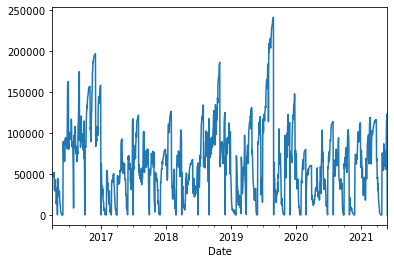

In [73]:
_delta['Total_delta'].plot()

<AxesSubplot:xlabel='Date'>

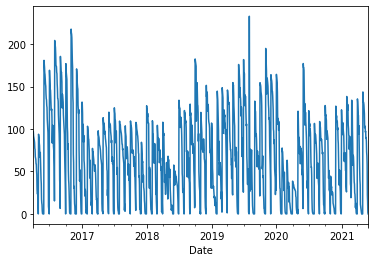

In [74]:
_vega['Total_vega'].plot()

In [75]:
_delta

,USDCNY_delta,USDBRL_delta,USDZAR_delta,USDRUB_delta,EURUSD_delta,USDJPY_delta,USDMXN_delta,USDCAD_delta,Total_delta
Date,,,,,,,,,
2016-04-01,0.0,0.0,0,0.0,48493.266674,0.000000,0.0,0.0,48493.266674
2016-04-04,0.0,0.0,0,0.0,48822.936661,0.000000,0.0,0.0,48822.936661
2016-04-05,0.0,0.0,0,0.0,47798.022000,0.000000,0.0,0.0,47798.022000
2016-04-06,0.0,0.0,0,0.0,49784.586746,0.000000,0.0,0.0,49784.586746
2016-04-07,0.0,0.0,0,0.0,46752.664035,0.000000,0.0,0.0,46752.664035
...,...,...,...,...,...,...,...,...,...
2021-05-26,0.0,0.0,0,0.0,0.000000,82685.125902,0.0,0.0,82685.125902
2021-05-27,0.0,0.0,0,0.0,0.000000,114070.466183,0.0,0.0,114070.466183
2021-05-28,0.0,0.0,0,0.0,0.000000,117828.799915,0.0,0.0,117828.799915


In [77]:
_delta.loc['2016-09-30'] # its zero because is an options maturity date 

USDCNY_delta    0.0
USDBRL_delta    0.0
USDZAR_delta    0.0
USDRUB_delta    0.0
EURUSD_delta    0.0
USDJPY_delta    0.0
USDMXN_delta    0.0
USDCAD_delta    0.0
Total_delta     0.0
Name: 2016-09-30 00:00:00, dtype: float64

In [80]:
# Risk dates are the dates where new options are bought
risk_dates

DatetimeIndex(['2016-04-01', '2016-05-02', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01',
               '2016-12-01', '2017-01-02', '2017-02-01', '2017-03-01',
               '2017-04-03', '2017-05-01', '2017-06-01', '2017-07-03',
               '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-02', '2018-05-01', '2018-06-01', '2018-07-02',
               '2018-08-01', '2018-09-03', '2018-10-01', '2018-11-01',
               '2018-12-03', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-03', '2019-07-01',
               '2019-08-01', '2019-09-02', '2019-10-01', '2019-11-01',
               '2019-12-02', '2020-01-01', '2020-02-03', '2020-03-02',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-03', '2020-09-01', '2020-10-01', '2020-11-02',
      

# Risk Management - VaR CVaR

In [97]:
def VaR_CVaR_MC(factReturns, risk_position, spot_vols, numTrials, alpha1=5, alpha2=1):

    # We assume the FX spot prices and ATM volatilities follow a multivariate-normal structure with
    # corresponding correlation matrix.
    
    # risk_position is delta+vega position in USD 
    
    # spot_vols is spot+ATMvol - we assume a parallel shift in the whole surface
    
    mean = factReturns.mean()
    cov = factReturns.cov()
    
    trialReturns = []
    for i in range(numTrials):

        # Generate the sample of factor returns
        trialFactorReturns = np.random.multivariate_normal(mean,cov)

        # Calculate the returns of each instrument, and then calculate teh total returns for this trial.
        #trailTotalReturn = np.dot(self.weight, trialFactorReturns)

        trialReturns.append(trialFactorReturns)

    df = pd.DataFrame(trialReturns)
    # Risk if we are long (delta and vega)
    VaR95_p = df.quantile(alpha1/100,interpolation='linear')
    cVaR95_p = df[df<= VaR95_p].mean()
    VaR99_p = df.quantile(alpha2/100,interpolation='linear')
    cVaR99_p = df[df<= VaR99_p].mean()
    # Risk if we are long (delta and vega)
    VaR95_m = df.quantile((100-alpha1)/100,interpolation='linear')
    cVaR95_m = df[df>= VaR95_m].mean()
    VaR99_m = df.quantile((100-alpha2)/100,interpolation='linear')
    cVaR99_m = df[df>= VaR99_m].mean()
    # Choose the side according to the metric
    VaR95 = pd.Series(np.zeros(16))
    cVaR95 = pd.Series(np.zeros(16))
    VaR99 = pd.Series(np.zeros(16))
    cVaR99 = pd.Series(np.zeros(16))
    for i in range(len(risk_position)):
        if i < 8:
            aux = 1 # For delta position
        else:
            aux = spot_vols[i] # For vega position
        #Calculate risks
        if risk_position[i]>=0:
            VaR95[i] = VaR95_p[i] * risk_position[i] * aux
            cVaR95[i] = cVaR95_p[i] * risk_position[i]* aux
            VaR99[i] = VaR99_p[i] * risk_position[i]* aux
            cVaR99[i] = cVaR99_p[i] * risk_position[i]* aux
        else:
            VaR95[i] = VaR95_m[i] * risk_position[i]* aux
            cVaR95[i] = cVaR95_m[i] * risk_position[i]* aux
            VaR99[i] = VaR99_m[i] * risk_position[i]* aux
            cVaR99[i] = cVaR99_m[i] * risk_position[i]* aux

    return VaR95, cVaR95, VaR99, cVaR99, VaR95_p, cVaR95_p, VaR99_p, cVaR99_p, VaR95_m, cVaR95_m, VaR99_m, cVaR99_m

In [99]:
# Create a list for dates to calibrate risk_metrics - how much history to calculate VaR and cVaR
# in this case we are using 5 years 
start = pd.to_datetime('2011-04-01')
end = pd.to_datetime('2021-06-01')
calibrate_risk = pd.date_range(start, end, freq='MS')
print(len(calibrate_risk))
calibrate_risk

123


DatetimeIndex(['2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01',
               ...
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', length=123, freq='MS')

In [101]:
# Generate a list with all the PnL DataFrames
# yearly so i + 60, 5 years of history to calibrate
n = 1000   #number of trials
# risk_dates are the dates where option strategies start 
# calibrate_risk are dates that help us to calibrate the multivariate normal distribution
risk_df = pd.DataFrame()

for i in range(len(risk_dates)):
    # Generate the returns history to calibrate multivariate normal distribution
    tdate1 = calibrate_risk[i]
    tdate2 = calibrate_risk[i+60]
    returns_risk = retfxvol[(tdate1<=retfxvol.index)&(retfxvol.index<=tdate2)].copy()

    # Get the risk positions 
    risk_pos = _delta.loc[risk_dates[i]][:-1].append(_vega.loc[risk_dates[i]][:-1])
    
    # Get the prices (spot-vols)
    prices = spot_vols.loc[risk_dates[i]]
    
    # Calculate numeric VaR and cVar
    #VaR95, cVaR95, VaR99, cVaR99 = VaR_CVaR_MC(returns_risk, risk_pos, prices, n)
    risk1 = VaR_CVaR_MC(returns_risk, risk_pos, prices, n)
        
    # Join a DataFrame
    #aux_df = pd.DataFrame(np.array([[VaR95.sum(),cVaR95.sum(),VaR99.sum(),cVaR99.sum()]]), \
                          #columns=['VaR95', 'cVar95', 'VaR99','cVaR99'])
    aux_df = pd.DataFrame(np.array([[risk1[0].sum(),risk1[1].sum(),risk1[2].sum(),risk1[3].sum()]]), \
                          columns=['VaR95', 'cVar95', 'VaR99','cVaR99'])
        
    risk_df = pd.concat([risk_df,aux_df])
# set index to  be the pnl dates
risk_df.index = risk_dates
# Rename index column
risk_df = risk_df.reset_index().rename(columns={'index':'Date'}).set_index('Date').copy()
risk_df = risk_df.round(2)
risk_df

,VaR95,cVar95,VaR99,cVaR99
Date,,,,
2016-04-01,-504.87,-633.42,-750.67,-817.66
2016-05-02,-479.87,-590.53,-666.01,-779.59
2016-06-01,-339.75,-419.06,-462.61,-528.00
2016-07-01,-304.48,-382.42,-430.35,-486.87
2016-08-01,-364.39,-455.42,-510.41,-577.18
...,...,...,...,...
2021-01-01,-473.27,-574.96,-619.86,-705.17
2021-02-01,-556.53,-681.90,-776.30,-873.68
2021-03-01,-589.53,-759.67,-909.23,-1030.99


In [138]:
# Code finishes

# Reconcile the first row of risk metrics VaR and cVaR (95 and 99)

In [139]:
tdate1 = calibrate_risk[0]
tdate2 = calibrate_risk[60]
returns_risk = retfxvol[(tdate1<=retfxvol.index)&(retfxvol.index<=tdate2)].copy()
returns_risk

,USDCNYspot,USDBRLspot,USDZARspot,USDRUBspot,EURUSDspot,USDJPYspot,USDMXNspot,USDCADspot,USDCNYvol,USDBRLvol,USDZARvol,USDRUBvol,EURUSDvol,USDJPYvol,USDMXNvol,USDCADvol
Date,,,,,,,,,,,,,,,,
2011-04-01,-0.001099,-0.015865,-0.011293,-0.003011,0.005580,0.011187,-0.005569,-0.007624,0.014161,-0.011550,-0.005791,-0.019952,-0.007838,-0.006074,-0.014595,-0.011675
2011-04-04,-0.000031,0.000622,0.003300,-0.001718,-0.001124,0.000000,0.000963,0.003945,-0.002148,0.008082,0.004368,-0.020359,-0.030437,-0.029245,-0.005107,-0.005907
2011-04-05,-0.000672,0.001182,0.000833,0.000484,0.000141,0.009636,-0.002684,-0.003309,-0.002153,-0.018835,-0.005074,0.015509,-0.008387,-0.009892,-0.032033,-0.018419
2011-04-06,0.000642,0.003169,-0.005948,-0.005483,0.007593,0.007305,-0.000990,-0.003113,0.000000,0.018704,0.001093,0.002443,0.014258,0.026794,-0.008485,0.002119
2011-04-07,-0.000107,-0.017280,-0.002992,0.003005,-0.001605,-0.006784,-0.002829,-0.002706,0.010787,-0.005605,0.000910,-0.001828,0.005242,0.024326,-0.005670,-0.001510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-28,-0.001304,-0.013353,0.001333,0.000808,0.002597,0.003272,-0.005958,-0.006255,0.005392,0.010788,0.002070,0.003048,0.017090,0.010947,-0.016202,0.013118
2016-03-29,0.000046,0.002839,-0.019805,-0.006049,0.008485,-0.006611,-0.005128,-0.008569,-0.052199,-0.014942,-0.016407,-0.004087,-0.036966,0.000000,0.015677,-0.008324
2016-03-30,-0.006070,-0.008740,-0.015129,0.002296,0.004163,-0.002396,-0.006503,-0.008261,-0.054696,-0.011070,-0.011121,-0.020730,-0.025922,-0.046139,0.010134,-0.032408


In [104]:
returns_risk.min()

USDCNYspot   -0.011880
USDBRLspot   -0.057909
USDZARspot   -0.049543
USDRUBspot   -0.159250
EURUSDspot   -0.021107
USDJPYspot   -0.029744
USDMXNspot   -0.037916
USDCADspot   -0.019495
USDCNYvol    -0.200504
USDBRLvol    -0.149311
USDZARvol    -0.113467
USDRUBvol    -0.136768
EURUSDvol    -0.116988
USDJPYvol    -0.121165
USDMXNvol    -0.158192
USDCADvol    -0.122761
dtype: float64

In [105]:
# Get the risk positions 
risk_pos = _delta.loc[risk_dates[0]][:-1].append(_vega.loc[risk_dates[0]][:-1])
risk_pos

USDCNY_delta        0.000000
USDBRL_delta        0.000000
USDZAR_delta        0.000000
USDRUB_delta        0.000000
EURUSD_delta    48493.266674
USDJPY_delta        0.000000
USDMXN_delta        0.000000
USDCAD_delta        0.000000
USDCNY_vega         0.000000
USDBRL_vega         0.000000
USDZAR_vega         0.000000
USDRUB_vega         0.000000
EURUSD_vega        96.887532
USDJPY_vega         0.000000
USDMXN_vega         0.000000
USDCAD_vega         0.000000
Name: 2016-04-01 00:00:00, dtype: float64

In [106]:
# Get the prices (spot-vols)
prices = spot_vols.loc[risk_dates[0]]
prices

USDCNYspot      6.4818
USDBRLspot      3.5540
USDZARspot     14.7010
USDRUBspot     67.5662
EURUSDspot      1.1391
USDJPYspot    111.6900
USDMXNspot     17.3391
USDCADspot      1.3011
USDCNYvol       6.2950
USDBRLvol      22.2980
USDZARvol      19.4275
USDRUBvol      22.7575
EURUSDvol      10.1850
USDJPYvol       9.9300
USDMXNvol      13.4680
USDCADvol      10.2575
Name: 2016-04-01 00:00:00, dtype: float64

In [107]:
# Calculate numeric VaR and cVar
#VaR95, cVaR95, VaR99, cVaR99 = VaR_CVaR_MC(returns_risk, risk_pos, prices, 1000)
risks_metrics = VaR_CVaR_MC(returns_risk, risk_pos, prices, 1000)

In [110]:
risks_metrics[0].sum()

-515.7070311233573

In [111]:
risks_metrics[0]

0      -0.000000
1      -0.000000
2      -0.000000
3      -0.000000
4    -471.161942
5      -0.000000
6      -0.000000
7      -0.000000
8      -0.000000
9      -0.000000
10     -0.000000
11     -0.000000
12    -44.545089
13     -0.000000
14     -0.000000
15     -0.000000
dtype: float64

In [112]:
risks_metrics[4]

0    -0.002248
1    -0.017110
2    -0.015246
3    -0.020969
4    -0.009716
5    -0.008580
6    -0.011178
7    -0.008347
8    -0.138840
9    -0.051844
10   -0.037541
11   -0.054451
12   -0.045141
13   -0.051526
14   -0.051153
15   -0.042433
Name: 0.05, dtype: float64

In [125]:
# Delta impact 
# Value of delta 
risk_pos[4]

48493.266674305756

In [126]:
# how much the underlying can change 
risks_metrics[4][4]

-0.00971602811054818

In [127]:
# Impact of delta in 1 day 
risk_pos[4] * risks_metrics[4][4]

-471.16194217986396

In [128]:
# How much is the vega risk 
risk_pos[12] 

96.88753169771911

In [129]:
# how much is the vol spot
prices[12]

10.185

In [130]:
# How much the volatility can move 
risks_metrics[4][12]

-0.04514097187592662

In [131]:
# Hoe much in vol terms the vol can change 
prices[12] * risks_metrics[4][12]

-0.45976079855631263

In [133]:
# pnl if the volatilty changes that amount
risk_pos[12] * prices[12] * risks_metrics[4][12]

-44.54508894349339

In [134]:
# Check the minimum of the calibration period, to see if higher than VaR99 and cVaR99
risk_pos[4] * returns_risk.min()[4]

-1023.5675776273854

In [135]:
risk_pos[12] * prices[12] * returns_risk.min()[12]

-115.44371551412972

In [136]:
# Done OK 

# Older things - Trash

In [41]:
start = dates_to_split[0]
end = dates_to_split[1]
strategy = transform(weights)
cash = 1000
test = FX_Volatility.performe(vols_dict[ccy_order[6]],riskfree, start, end, bos, strategy[1], cash)

/Users/PlumpsCrap/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


In [ ]:

# Get the strategy by CCY 




# Define available cash and cash per currency
all_cash = 100000 * .20
count_3 = np.count_nonzero(strategies == 3)
cash_p1 = all_cash / (8- count_3)
# Define Bid-Offer spread (in vegas)
bos = 0.75
# Consolidate to one DataFrame with the same dates than returns
all_pnl = allbase.copy()
start = dates[0] 
end = dates[1]
all_pnl = all_pnl[(start<=all_pnl.index)&(all_pnl.index<=end)]
all_pnl.drop(list(all_pnl.columns),axis=1,inplace=True)
# Define dates of exercies 
for i in range(8):
    pnl_i = performe(globals()[ccy[i]],allbase['RFR'], dates[0],dates[1], bos, strategies[i],cash_p1).pnl()
    all_pnl = all_pnl.join(pnl_i)
# Generate a column for all pnl 
suffix = ['_spot', '_premium','_mv','_pnl', '_delta', '_gamma','_vega','_theta']
just_pnl = all_pnl.copy()
for i in just_pnl.columns:
    if i[6:] == suffix[3]:
        pass
    else:
        just_pnl.drop(i,axis=1,inplace=True)

In [3]:
rets = pd.read_csv("returns.csv")[1:] # without the first row of NA
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [4]:
ccy_list = ['USA_MXN=X', 'USA_JPY=X', 'USA_EUR=X', 'USA_RUB=X', 'USA_ZAR=X', 'USA_BRL=X', 'USA_CNY=X']

In [5]:
for i in rets.columns:
    if not i in ccy_list:
        rets.drop(i, axis=1, inplace=True)
rets.head()

,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,
2011-01-04,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [282]:
vols_dict['USDCNY'].loc['2013-01-01']

USDCNYspot       6.2303
USDCNY1WFWD    632.0000
USDCNY1MFWD    754.0000
USDCNY3MFWD    780.0000
USDCNY1WATM      1.5500
USDCNY1WRR       0.1750
USDCNY1WBF       0.1275
USDCNY1MATM      1.7025
USDCNY1MRR       0.1975
USDCNY1MBF       0.0575
USDCNY3MATM      1.7450
USDCNY3MRR       0.2225
USDCNY3MBF       0.1075
Name: 2013-01-01 00:00:00, dtype: float64

In [463]:
# OLD SHARPE RATIO 

# Maximum Sharpe Ratio Portfolio
# def sharpe_ratio_calculation(w,_return,_cov):
#     return - _return.mul(w,axis=1).sum(axis=1).cumsum()[-1]/np.sqrt(np.dot(w.T,np.dot(_cov,w)))

# def sharpe_ratio_maximization(portfolio):
#     _return = portfolio
#     _cov = portfolio.cov()
#     n = _cov.shape[0]
#     constraints = [{'type':'eq','fun': lambda x: sum(x)-1}]
#     outcome = minimize(sharpe_ratio_calculation,x0 = np.repeat(1/n,n),args = (_return,_cov), 
#                        constraints = constraints, bounds= tuple((-1,1) for x in range(n)))
#     return outcome.x

In [82]:
# Get a test sample of returns 
tdate1 = dates_sample[0]
tdate2 = dates_sample[1]
test_returns = retfxvol[(tdate1<=retfxvol.index)&(retfxvol.index<=tdate2)].copy()
test_returns.head(2)

,USDCNYspot,USDBRLspot,USDZARspot,USDRUBspot,EURUSDspot,USDJPYspot,USDMXNspot,USDCADspot,USDCNYvol,USDBRLvol,USDZARvol,USDRUBvol,EURUSDvol,USDJPYvol,USDMXNvol,USDCADvol
Date,,,,,,,,,,,,,,,,
2016-01-01,0.000000,0.000000,0.005754,0.000000,-0.000552,0.002745,0.003202,0.001156,0.004979,-0.002637,-0.005592,0.001124,-0.000755,-0.001869,0.002847,0.001929
2016-01-04,0.006129,0.018946,0.001208,-0.005791,-0.002303,-0.009208,0.002699,0.007073,0.021341,0.013574,0.011514,-0.022325,0.007049,0.084582,0.005590,0.025034


In [299]:
# Random Risk position 
risk_pos_test = (np.random.rand(16)- 0.5) *1000
risk_pos_test

array([ 484.34176946,  392.16311673,  -24.98351936, -258.78322217,
        142.05375205,  225.26089532,   39.82337072, -237.17157389,
        441.13337736, -173.80098402,  145.81938763, -422.8966796 ,
        -24.88764675,  451.61758532,  -62.83115102, -198.388011  ])

In [300]:
# Random Risk position 
spot_vols_test = np.random.rand(16)*1000
spot_vols_test

array([ 80.82015917, 196.73582347, 319.5871676 ,  72.50030022,
        99.48792856, 582.62409884, 443.50189943, 789.07206717,
       411.07192809, 883.34306305, 705.11235327, 824.23898674,
       884.20322798, 102.29949391, 393.33086135, 201.98364074])

In [301]:
# Test risk_metrics
VaR95, cVaR95, VaR99, cVaR99 = VaR_CVaR_MC(test_returns, risk_pos_test, spot_vols_test, 3)

In [302]:
type(VaR95)

pandas.core.series.Series

In [303]:
cVaR99

0        -1.323497
1        -2.043789
2        -0.057671
3        -5.383195
4        -0.919508
5        -1.248726
6         0.161335
7        -0.658739
8     -8713.771863
9     -9883.937699
10    -4812.010583
11   -24208.825189
12     -428.572335
13    -2986.618560
14     -465.426324
15    -1823.891249
dtype: float64

In [84]:
_delta[_delta.index>='2016-04-29']

,USDCNY_delta,USDBRL_delta,USDZAR_delta,USDRUB_delta,EURUSD_delta,USDJPY_delta,USDMXN_delta,USDCAD_delta,Total_delta
Date,,,,,,,,,
2016-04-29,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2016-05-02,0.0,0.0,0,0.0,44632.703900,0.000000,0.0,0.0,44632.703900
2016-05-03,0.0,0.0,0,0.0,40397.480135,0.000000,0.0,0.0,40397.480135
2016-05-04,0.0,0.0,0,0.0,39350.120899,0.000000,0.0,0.0,39350.120899
2016-05-05,0.0,0.0,0,0.0,30290.872228,0.000000,0.0,0.0,30290.872228
...,...,...,...,...,...,...,...,...,...
2021-05-26,0.0,0.0,0,0.0,0.000000,82685.125902,0.0,0.0,82685.125902
2021-05-27,0.0,0.0,0,0.0,0.000000,114070.466183,0.0,0.0,114070.466183
2021-05-28,0.0,0.0,0,0.0,0.000000,117828.799915,0.0,0.0,117828.799915


In [85]:
print(dates_to_split[1])
_delta.loc[dates_to_split[1]]

2016-05-01 00:00:00


KeyError: Timestamp('2016-05-01 00:00:00', freq='MS')

In [346]:
_vega.loc[dates_to_split[1]]

USDCNY_vega    9541.002109
USDBRL_vega       0.000000
USDZAR_vega       0.000000
USDRUB_vega       0.000000
EURUSD_vega     146.868055
USDJPY_vega       0.000000
USDMXN_vega       0.000000
USDCAD_vega       0.000000
Total_vega     9687.870164
Name: 2016-07-01 00:00:00, dtype: float64

In [347]:
risk_pos = _delta.loc[dates_to_split[1]][:-1].append(_vega.loc[dates_to_split[1]][:-1])
risk_pos

USDCNY_delta    109825.962718
USDBRL_delta         0.000000
USDZAR_delta         0.000000
USDRUB_delta         0.000000
EURUSD_delta     60287.014481
USDJPY_delta         0.000000
USDMXN_delta         0.000000
USDCAD_delta         0.000000
USDCNY_vega       9541.002109
USDBRL_vega          0.000000
USDZAR_vega          0.000000
USDRUB_vega          0.000000
EURUSD_vega        146.868055
USDJPY_vega          0.000000
USDMXN_vega          0.000000
USDCAD_vega          0.000000
Name: 2016-07-01 00:00:00, dtype: float64

In [341]:
calibrate_risk

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
      